### This Notebook Performs the necessary Preprocessing, EDA and fits the Neural Network and K-Nearest Neighbors models!

In [43]:
# Import necessary libraries
import pandas as pd  # Pandas library for data manipulation and analysis
import numpy as np  # Numpy library for numerical operations
import seaborn as sns  # Seaborn library for data visualization
import matplotlib.pyplot as plt  # Matplotlib library for plotting data
from sklearn.model_selection import train_test_split  # Train-test split for data splitting
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
import torch  # PyTorch library for deep learning
import torch.nn as nn  # PyTorch modules for defining neural networks
import torch.optim as optim  # PyTorch optimizers for training neural networks
from torch.utils.data import DataLoader, TensorDataset  # PyTorch data loaders for handling datasets
from sklearn.model_selection import train_test_split  # Train-test split for data splitting
from sklearn import datasets  # Scikit-learn datasets
from sklearn.metrics import accuracy_score  # Accuracy score for model evaluation
from sklearn.metrics import roc_auc_score  # ROC-AUC score for model evaluation
from sklearn.preprocessing import StandardScaler  # StandardScaler for data preprocessing
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
import plotly  # Plotly library for interactive visualizations
import plotly.offline as pyo  # Plotly offline mode for generating HTML visualizations
import plotly.express as px  # Plotly Express for creating visualizations easily
import missingno as msno  # Missingno library for visualizing missing data
from sklearn.model_selection import GridSearchCV  # GridSearchCV for hyperparameter tuning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [44]:
#Load the data and also the necessary colors
df=pd.read_csv("water_potability.csv")
y=df.Potability
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [45]:
# Visualizing the Data
df.describe().style.background_gradient(cmap = "Blues")

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


### Examining the classification and checking for Imbalance

In [46]:
d= pd.DataFrame(df['Potability'].value_counts())
# fig = px.pie(d,values='Potability',names=['Not Potable','Potable'],hole=0.4,opacity=0.6,
#             color_discrete_sequence=[colors_green[3],colors_blue[3]],
#              labels={'label':'Potability','Potability':'No. Of Samples'})
fig = px.pie(d, values='count', names=['Not Potable', 'Potable'], hole=0.4, opacity=0.6,
             color_discrete_sequence=['red',colors_green[3]],
             labels={'label': 'Potability', 'count': 'No. Of Samples'})


# fig.add_annotation(text='We can See that the data is imbalanced <br> and hence we need to balance it!',
#                    x=1.2,y=0.9,showarrow=False,font_size=12,opacity=0.7,font_family='monospace')
fig.add_annotation(text='Potability',
                   x=0.5,y=0.5,showarrow=False,font_size=14,opacity=0.7,font_family='monospace')

fig.update_layout(
    font_family='monospace',
    title=dict(text='Potability of Water',x=0.47,y=0.98,
               font=dict(color='black',size=20)),
    legend=dict(x=0.37,y=-0.05,orientation='h',traceorder='reversed'),
    hoverlabel=dict(bgcolor='white'),
    width=600
    )

fig.update_traces(textposition='outside', textinfo='percent+label')

fig.show()

### Checking for empty values

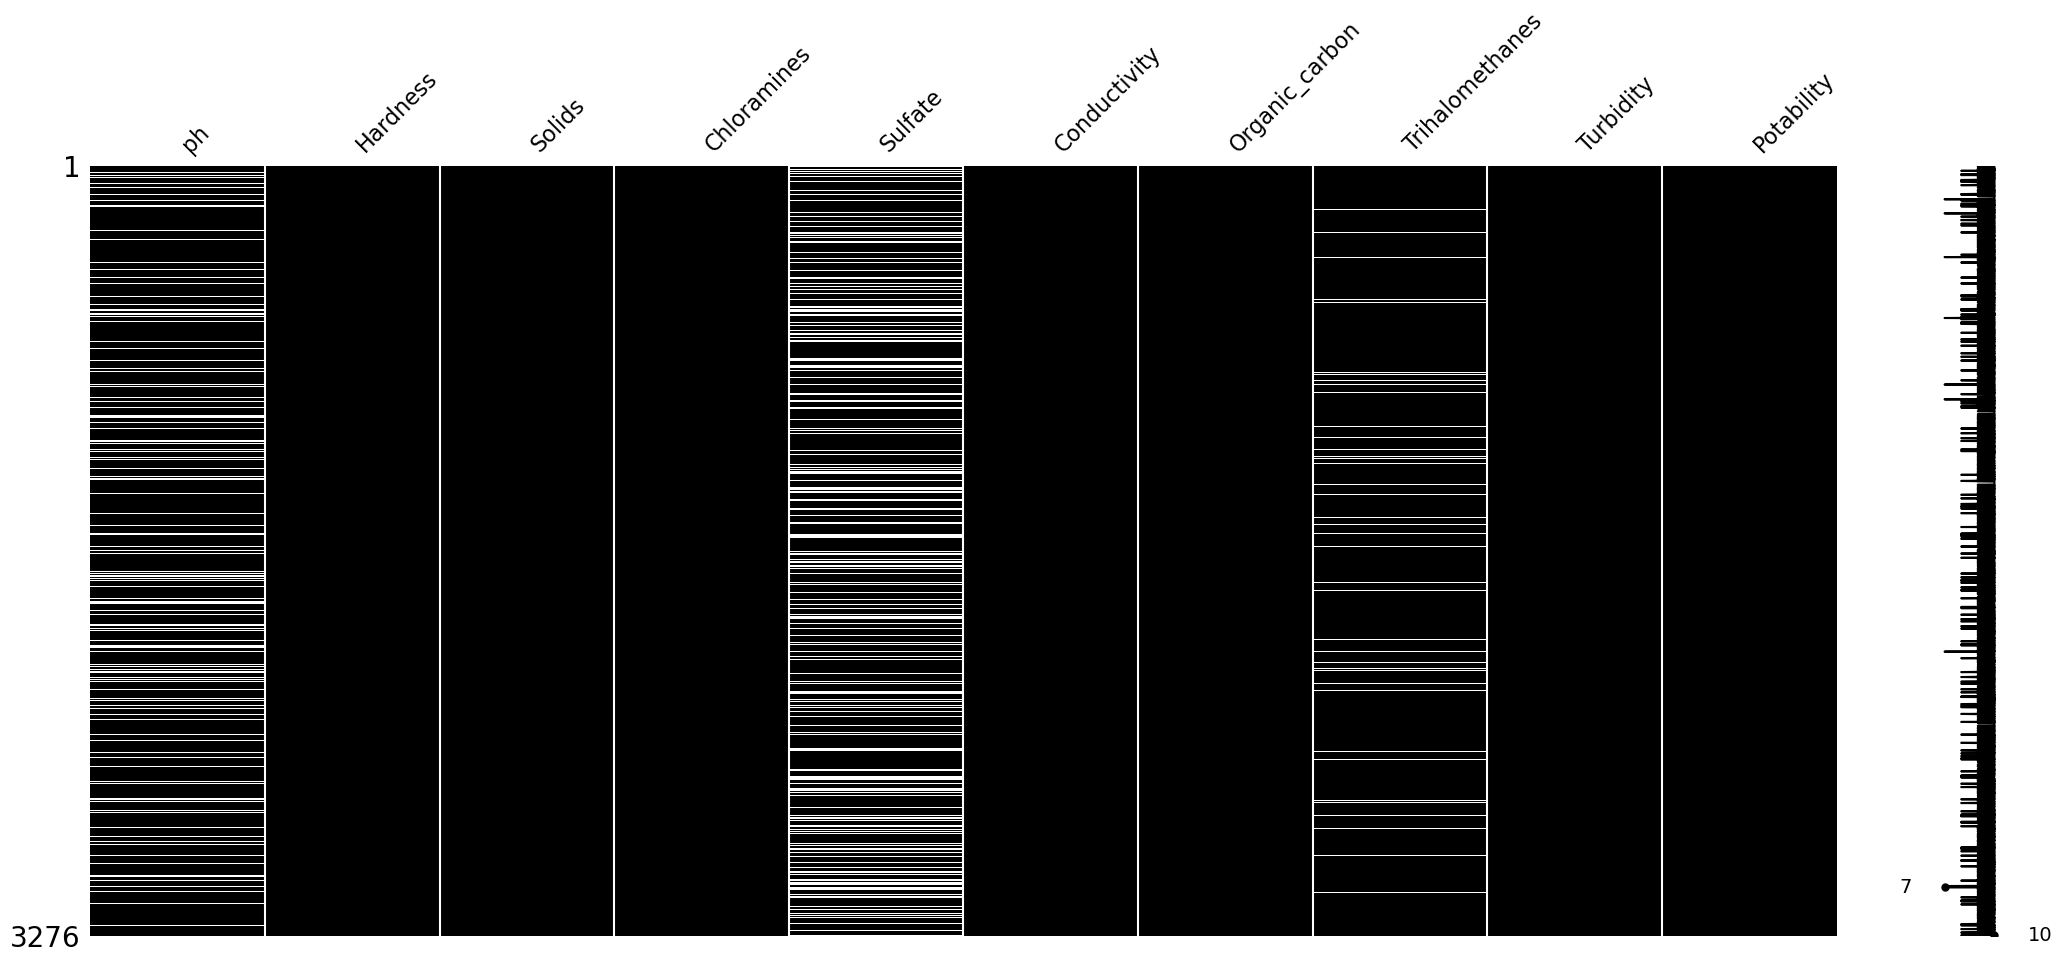

In [47]:
fig = msno.matrix(df,color=(0,0,0))

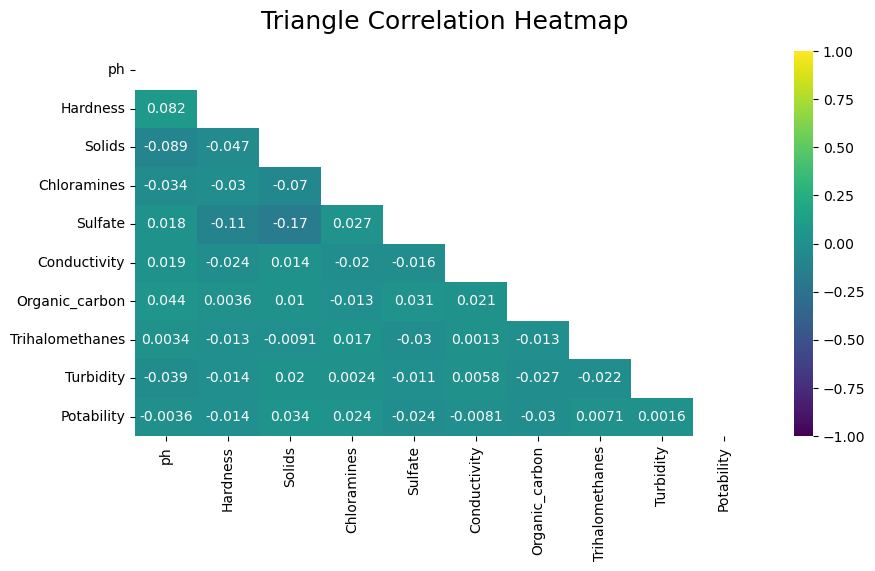

In [48]:
# Checking for Correlations between the features and Target Variable
plt.figure(figsize=(10, 5))

# Define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))  # Replace np.bool with bool

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='viridis')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)

plt.show()


From the Above Correlation Graph we see that there is very little correlation between any of the variables in our case

In [49]:
#Counting the number of null values
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

This shows us that ph, Sulfate, and Trihalomethanes have null cells which could lead to issues for our classification problem. Hence we must either fill in the gaps or drop these cells. Since the number of cells with empties are pretty high, we just fill them up with the median values. For Trihalomethanes there are not that many null values and so we just delete those.

In [50]:
df['ph'].fillna(value=df['ph'].median(),inplace=True)
df['Sulfate'].fillna(value=df['Sulfate'].median(),inplace=True)
# df.dropna(subset=['ph'], inplace=True)
# df.dropna(subset=['Sulfate'], inplace=True)
df.dropna(subset=['Trihalomethanes'], inplace=True)
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [51]:
zero  = df[df['Potability']==0]   #zero values in Potability column
one = df[df['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
df_minority_upsampled = resample(one, replace = True, n_samples = 1891) 
#concatenate
df= pd.concat([zero, df_minority_upsampled])
from sklearn.utils import shuffle
df = shuffle(df) # shuffling so that there is particular sequence
df.Potability.value_counts()

Potability
1    1891
0    1891
Name: count, dtype: int64

In [52]:
X = df.drop('Potability',axis=1).values
y = df['Potability'].values


In [53]:
#Using Standard Scaler to normalise our features to ensure better computation and faster convergence
scale = StandardScaler()
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.2,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

$\textbf{Neural Networks}$

In [54]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=3000, shuffle=True)

# Define the neural network model using torch.nn.Sequential
model = nn.Sequential(
    nn.Linear(9, 100),
    nn.ReLU(),
    nn.Dropout(0.5),  # Example of dropout for regularization
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(50, 2),
    nn.Sigmoid()  # Example of using sigmoid for binary classification
)


# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
                    #   ,weight_decay=0.01)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Flatten the input data
        batch_X = batch_X.view(-1, 9)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        # L2 regularization term
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        
        # Add L2 regularization to the loss
        loss += 0.01 * l2_reg  # You can adjust the regularization strength

        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    # Convert the test data to PyTorch tensor
    X_test_tensor = X_test_tensor.view(-1,9)
    
    # Forward pass
    outputs = model(X_test_tensor)
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

# Convert predictions to numpy array
predicted_np = predicted.numpy()

# Calculate and print the accuracy
accuracy = roc_auc_score(y_test, predicted_np)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 50.37%


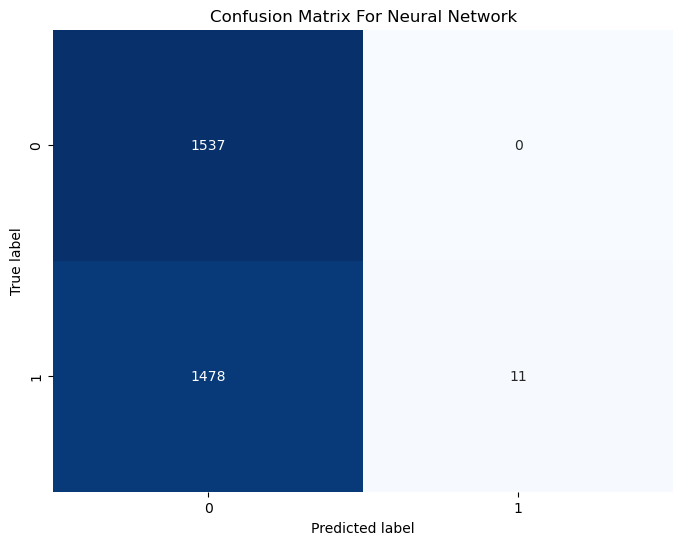

Test ROC AUC: 50.37%


In [55]:
# Generate confusion matrix for Neural Network
cm = confusion_matrix(y_test, predicted_np)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix For Neural Network')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, predicted_np)
print(f'Test ROC AUC: {roc_auc * 100:.2f}%')

$\textbf{K-Nearest Neighbors}$

In [56]:

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7],  # You can adjust this range based on your preference
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create KNeighborsClassifier model
knn_model = KNeighborsClassifier()

# Create GridSearchCV object for Cross Val
grid_search = GridSearchCV(knn_model, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_knn_model = grid_search.best_estimator_

# Evaluate on the test set
test_acc = accuracy_score(y_test, best_knn_model.predict(X_test_scaled))
test_precision=precision_score(y_test, best_knn_model.predict(X_test_scaled))
test_recall=recall_score(y_test, best_knn_model.predict(X_test_scaled))
f1_score=f1_score(y_test, best_knn_model.predict(X_test_scaled))
roc_score=roc_auc_score(y_test, best_knn_model.predict(X_test_scaled))
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Test Accuracy with the best model: {test_acc}")
print(f"Test Precision with the best model: {test_precision}")
print(f"Test Recall with the best model: {test_precision}")
print(f"Test F-1 Score with the best model: {f1_score}")
print(f"Test ROC Score with the best model: {roc_score}")

Best hyperparameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Test Accuracy with the best model: 0.6229345670852611
Test Precision with the best model: 0.5995423340961098
Test Recall with the best model: 0.5995423340961098
Test F-1 Score with the best model: 0.6475131294408402
Test ROC Score with the best model: 0.624197705751962


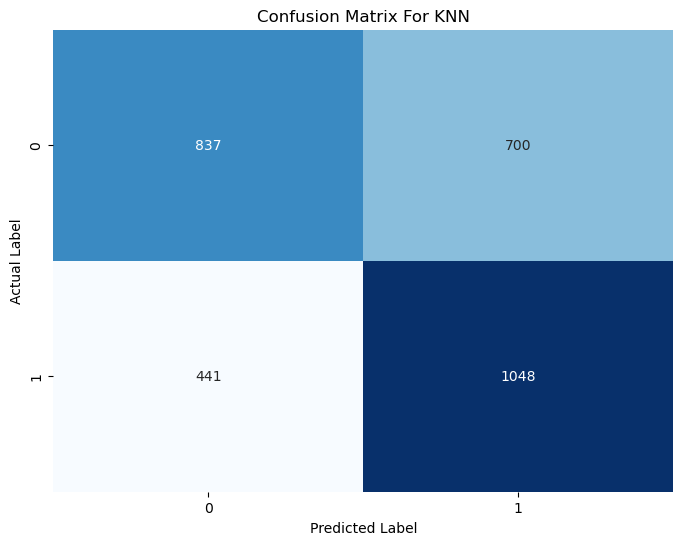

In [57]:
y_pred = best_knn_model.predict(X_test_scaled)

# Generate confusion matrix for KNN model
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_knn_model.classes_, yticklabels=best_knn_model.classes_)
plt.title('Confusion Matrix For KNN')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()